# Video Classification with a CNN-RNN Architecture

## Dependencies

In [ ]:
!pip install kagglehub imutils --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [116]:
import os

from imutils import paths

import imageio
import cv2
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import top_k_categorical_accuracy

import kagglehub

import warnings

## Data Loading

Get Tensorflow Docs

In [3]:
!pip install -q git+https://github.com/tensorflow/docs


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Acquire subsampled version of the original UCF101 dataset

In [4]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

Download latest version of the ucf101-action-recognition dataset

In [5]:
# path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

# print("Path to dataset files:", path)
# train_df = pd.read_csv(path+"/train.csv")
# train_df
# train_df["label"].unique()

Load the train and test datasets

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
158,v_PlayingCello_g13_c07.avi,PlayingCello
451,v_ShavingBeard_g22_c02.avi,ShavingBeard
315,v_Punch_g19_c03.avi,Punch
420,v_ShavingBeard_g17_c06.avi,ShavingBeard
252,v_Punch_g10_c01.avi,Punch
475,v_ShavingBeard_g25_c05.avi,ShavingBeard
236,v_PlayingCello_g25_c06.avi,PlayingCello
56,v_CricketShot_g16_c01.avi,CricketShot
96,v_CricketShot_g22_c05.avi,CricketShot
115,v_CricketShot_g25_c05.avi,CricketShot


## Hyperparameters

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100 # TODO: Use 100 for final training

MAX_SEQ_LENGTH = 20 # TODO: Check the distribution of the sequence lengths
NUM_FEATURES = 2048

## Data Preprocessing

#### Review Video frame distribution 

Count the number of frames for each video

In [214]:
def count_frames_per_video(video_paths, root_dir):
    frame_counts = []

    for path in video_paths:        
        video_path = os.path.join(root_dir, path)
        cap = cv2.VideoCapture(video_path)
        count = 0
        while cap.isOpened():
            ret, _ = cap.read()
            if not ret:
                break
            count += 1
        cap.release()
        frame_counts.append(count)

    return frame_counts

In [215]:
def visualize_frame_distribution(frame_counts):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=frame_counts)
    plt.title("Violin Plot of Frame Counts per Video")
    plt.xlabel("Number of Frames")
    plt.xlabel("Number of Frames")
    plt.show()

In [216]:
frame_counts = count_frames_per_video(train_df["video_name"].values, "train/")

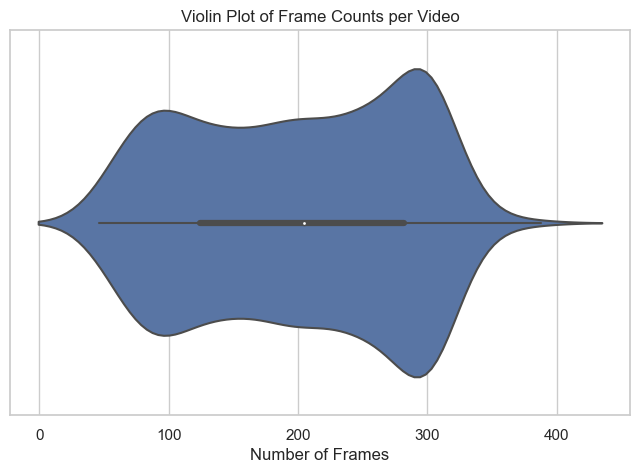

In [217]:
visualize_frame_distribution(frame_counts)

### Video preprocessing utilities

 Function to resize the video frames to a square shape without distorting their content

In [45]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]  # Get the height (y) and width (x) of the image
    min_dim = min(y, x)       # Find the smallest dimension (either height or width)
    start_x = (x // 2) - (min_dim // 2)  # Calculate the horizontal starting point for the crop
    start_y = (y // 2) - (min_dim // 2)  # Calculate the vertical starting point for the crop
    
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # Return the cropped square

Crop,resize, and reorder color channels

In [48]:
def load_and_preprocess_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame) # Crop center square
            frame = cv2.resize(frame, resize) # Resize the image (In this case to 224x224)
            frame = frame[:, :, [2, 1, 0]] # Reorder the color channels from OpenCV BGR to RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
   
    return np.array(frames)

### Feature Extraction

Using a pre-trained network to extract meaningful features from the extracted frames, the InceptionV3 model pretrained on ImageNet-1k dataset

In [10]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [11]:
feature_extractor = build_feature_extractor()

Encode the class labels as integers using the Keras StringLookup layer

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)

class_vocab = label_processor.get_vocabulary()

print(f"Vocabulary: {class_vocab}")


Vocabulary: ['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


label_processorExtract frame_features, frame_masks and labels
- `frame_features` will contain extracted features per frame
- `frame_masks` will contain booleans denoting if a timestep/frame is padded or not

Helper function to create masks and features for a single video

In [194]:
def create_video_mask_and_features(frames):
    frames = frames[None, ...]  # Add batch dimension
    video_length = min(MAX_SEQ_LENGTH, frames.shape[1])

    mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
    features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for j in range(video_length):
        features[0, j, :] = feature_extractor.predict(frames[:, j, :], verbose=0)
    mask[0, :video_length] = 1  # Set mask for valid frames

    return features, mask

Main function for video feature extraction

In [197]:
def extract_features_and_masks(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = keras.ops.convert_to_numpy(label_processor(df["tag"].values[..., None]))

    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for idx, video_path in enumerate(video_paths):
        frames = load_and_preprocess_video(os.path.join(root_dir, video_path))
        
        # Prepare masks and features for the current video
        features, mask = create_video_mask_and_features(frames)
        frame_features[idx] = features
        frame_masks[idx] = mask

    return (frame_features, frame_masks), labels


Extract the frame features, feature masks and labels for the `train` set

In [ ]:
train_data, train_labels = extract_features_and_masks(train_df, "train")

Extract the frame features, feature masks and labels for the `test` set

In [191]:
test_data, test_labels = extract_features_and_masks(test_df, "test")

In [57]:
total_samples, frame_count, num_of_features = train_data[0].shape

print(f"""Frame features in train set: {train_data[0].shape} 
    → {total_samples} samples
    → {frame_count} frames per video
    → {num_of_features} features per frame
""")

total_samples, mask_count = train_data[1].shape
print(f"""Frame masks in train set: {train_data[1].shape} 
    → {total_samples} samples
    → {mask_count} masks per video
""")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in train set: (594, 20, 2048) 
    → 594 samples
    → 20 frames per video
    → 2048 features per frame

Frame masks in train set: (594, 20) 
    → 594 samples
    → 20 masks per video

Frame features in test set: (224, 20, 2048)
Frame masks in test set: (224, 20)


## Sequence Model Architecture

Recurrent Neural Network architecture with GRU (Gated Recurrent Unit) layers

In [20]:
def build_rnn_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    # x = keras.layers.Dense(8, activation="relu")(x) # TODO: Experiment with the dense layers
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    # TODO: Check with categorical_crossentropy
    
    rnn_model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam",
        metrics=["accuracy"]
    )
    
    return rnn_model

Build the model

In [21]:
rnn_seq_model = build_rnn_sequence_model()

## Model Training

Utility to run the experiment

In [152]:
def train_and_evaluate_model(weights_file_path=None, seq_model=None):
    checkpoint = ModelCheckpoint(
        weights_file_path,
        monitor="val_loss",
        mode="min",  # Save the model when the loss decreases (when model improves)
        save_weights_only=True,
        save_best_only=True,
        verbose=1,
    )

    # TODO: Return this
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    )

    # Train the model
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    # Load the best weights after training
    seq_model.load_weights(weights_file_path)

    # Evaluate the model on a test sample
    print("\nEvaluating the model...")
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return seq_model, history

Run the experiment

In [153]:
weights_file_path = "models/ckpt.rnn_model.weights.h5"

sequence_model, history = train_and_evaluate_model(weights_file_path, rnn_seq_model)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6751 - loss: 1.2584
Epoch 1: val_loss improved from inf to 2.09862, saving model to models/ckpt.rnn_model.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6765 - loss: 1.2550 - val_accuracy: 0.0000e+00 - val_loss: 2.0986
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7884 - loss: 0.9822
Epoch 2: val_loss did not improve from 2.09862
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7882 - loss: 0.9780 - val_accuracy: 0.0670 - val_loss: 2.3646
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8334 - loss: 0.7188
Epoch 3: val_loss did not improve from 2.09862
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8343 - loss: 0.7162 - val_accuracy: 0.2570 - val_loss: 2.6668
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8789 - loss: 0.5896
Epoch 4: val_loss did not improve from 2.09862
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8786 - loss:

Visualise the training and validation loss and accuracy

In [154]:
def visualize_training_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

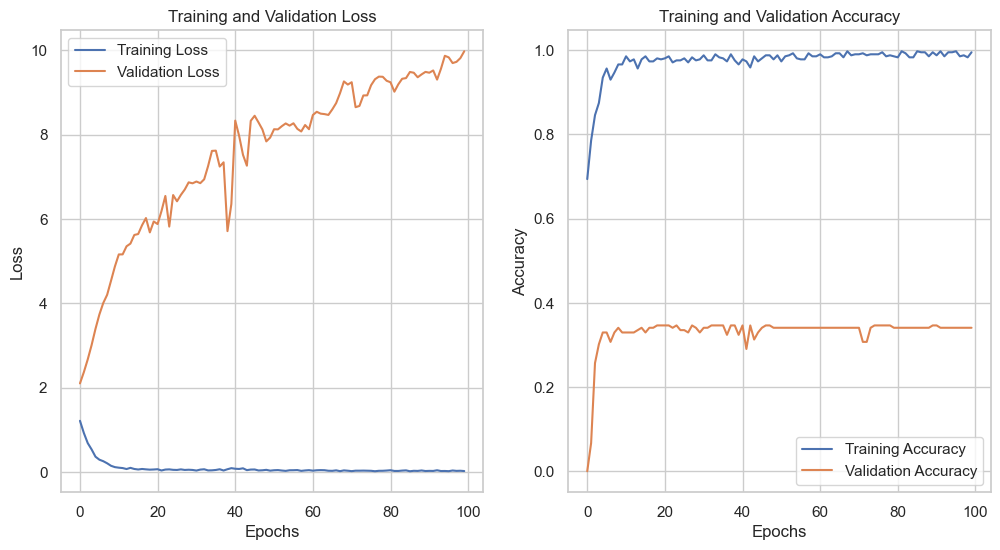

In [155]:
visualize_training_metrics(history)

## Model Evaluation

In [159]:
test_features, test_masks = test_data

Evaluate on the entire dataset

In [160]:
loss, accuracy = sequence_model.evaluate([test_features, test_masks], test_labels, batch_size=32)

print(f"Test Loss: {loss :.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8096 - loss: 1.1223
Test Loss: 1.3629
Test Accuracy: 56.70%


## Model testing

#### Evaluation with single sample

Function to prepare the test video

In [199]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ),dtype="bool" )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, frames_batch in enumerate(frames):
        video_length = frames_batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(frames_batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

Make predictions on a single video

In [211]:
def sequence_prediction(seq_model, frames, true_label):
    frame_features, frame_mask = create_video_mask_and_features(frames)
    probabilities = seq_model.predict([frame_features, frame_mask])[0]
        
    print("\nTop-5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  - {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    # Get the top-1 predicted label (highest probability)
    predicted_index = np.argmax(probabilities)
    predicted_label = class_vocab[predicted_index]

    # Convert true_label to index to align with predicted index format
    true_label_index = class_vocab.index(true_label)

    # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
    y_true = np.zeros(len(class_vocab))
    y_pred = np.zeros(len(class_vocab))
    y_true[true_label_index] = 1
    y_pred[predicted_index] = 1
 
    return y_true, y_pred, predicted_label

Display predicted image as GIF

In [201]:
def display_as_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")

Choosing a random video to use for prediction

Test video path: v_TennisSwing_g06_c02.avi
Label: TennisSwing

Test video frames shape:
  - 211 frames
  - 224 pixels (height) x 224 pixels (width)
  - 3 color channels



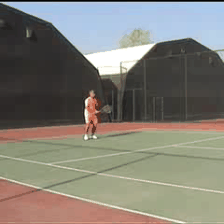

In [202]:
random_index = np.random.randint(len(test_df))

# Get the test video path
test_video = test_df["video_name"].values[random_index]

# Get the true label of the test video
true_label_index = test_labels.tolist()[random_index][0]
true_label = class_vocab[true_label_index]

test_video_frames = load_and_preprocess_video(os.path.join("test", test_video))

print(f"Test video path: {test_video}")
print(f"Label: {true_label}")

print(f"""
Test video frames shape:
  - {test_video_frames.shape[0]} frames
  - {test_video_frames.shape[1]} pixels (height) x {test_video_frames.shape[2]} pixels (width)
  - {test_video_frames.shape[3]} color channels
""")

display_as_gif(test_video_frames[:MAX_SEQ_LENGTH])

Run the prediction on the test video

In [212]:
y_true, y_pred, predicted_label = sequence_prediction(sequence_model, test_video_frames, true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Top-5 actions:
  - CricketShot: 32.24%
  - ShavingBeard: 22.36%
  - Punch: 19.62%
  - PlayingCello: 17.15%
  - TennisSwing:  8.62%


In [204]:
print(f"\nTrue label: {true_label}")
print(f"Predicted label: {predicted_label}")

print(f"y_true: {y_true}")
print(f"y_pred: {y_pred}")


True label: TennisSwing
Predicted label: CricketShot
y_true: [0. 0. 0. 0. 1.]
y_pred: [1. 0. 0. 0. 0.]


Evaluation Metrics

In [205]:
def display_evaluation_metrics(y_true, y_pred, predictions=None, target_classes=None):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")

    # Calculate Top-k accuracy
    if predictions is not None:
        k = 2
        top_k_acc = top_k_accuracy_score(y_true, predictions, k=k)
        print(f"Top-{k} Accuracy: {top_k_acc * 100:.2f}%")
        
        # TODO: Compare these
        # Using TensorFlow's top_k_categorical_accuracy
        # top_k_acc = top_k_categorical_accuracy(y_true, predictions, k=2).numpy().mean()

    report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
    print("Classification Report:\n", report)

In [206]:
display_evaluation_metrics(y_true, y_pred)

Top-1 Accuracy: 60.00%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5



#### Evaluation on the entire test set

In [207]:
predictions = sequence_model.predict([test_features, test_masks], batch_size=32)
predicted_classes = np.argmax(predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [208]:
display_evaluation_metrics(test_labels, predicted_classes, predictions, class_vocab)

Top-1 Accuracy: 56.70%
Top-2 Accuracy: 75.00%
Classification Report:
               precision    recall  f1-score   support

 CricketShot       0.34      1.00      0.51        49
PlayingCello       1.00      0.93      0.96        44
       Punch       0.95      0.95      0.95        39
ShavingBeard       0.00      0.00      0.00        43
 TennisSwing       0.00      0.00      0.00        49

    accuracy                           0.57       224
   macro avg       0.46      0.58      0.48       224
weighted avg       0.44      0.57      0.47       224



In [209]:
def display_confusion_matrix(y_true, y_pred, target_classes, show_plot=False):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    if show_plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=target_classes, yticklabels=target_classes)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    else:
        print(conf_matrix)

In [210]:
true_labels = np.array(test_labels).flatten()
display_confusion_matrix(true_labels, predicted_classes, class_vocab, show_plot=False)

[[49  0  0  0  0]
 [ 3 41  0  0  0]
 [ 2  0 37  0  0]
 [41  0  2  0  0]
 [49  0  0  0  0]]
